In [1]:
#Install Keras & Tensorflow
!pip install --upgrade tensorflow
!pip install Keras
!pip install keras-tqdm

!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gzip -d cc.en.300.vec.gz

import pickle
import numpy as np
import pandas as pd


idx = 0
vocab = {}
with open("cc.en.300.vec", 'r', encoding="utf-8", newline='\n',errors='ignore') as f:
    for l in f:
        line = l.rstrip().split(' ')
        if idx == 0:
            vocab_size = int(line[0]) + 2
            dim = int(line[1])
            vecs = np.zeros(vocab_size*dim).reshape(vocab_size,dim)
            vocab["__PADDING__"] = 0
            vocab["__UNK__"] = 1
            idx = 2
        else:
            vocab[line[0]] = idx
            emb = np.array(line[1:]).astype(np.float)
            if (emb.shape[0] == dim):
                vecs[idx,:] = emb
                idx+=1
            else:
                continue

    pickle.dump(vocab,open("fasttext_voc",'wb'))
    np.save("fasttext.npy",vecs)
    
fasttext_embed = np.load("fasttext.npy")
fasttext_word_to_index = pickle.load(open("fasttext_voc", 'rb'))

!wget https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (1.14.0)
--2019-07-10 09:46:38--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:16a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  41.0MB/s    in 33s     

2019-07-10 09:47:12 (38.1 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]

--2019-07-10 09:59:59--  https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.


In [2]:
def recall(y_true, y_pred):
    
    """
    Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    
    """
    Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    Source
    ------
    https://github.com/fchollet/keras/issues/5400#issuecomment-314747992
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    
    """Calculate the F1 score."""
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))


def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=1)
  
  
  
data = pd.read_csv('stack-overflow-data.csv')

Classes = list(data['tags'].value_counts().index)
Nclasses = len(Classes)
print(data['tags'].value_counts())

objective-c      2000
python           2000
sql              2000
c                2000
javascript       2000
iphone           2000
html             2000
asp.net          2000
ruby-on-rails    2000
css              2000
c#               2000
java             2000
android          2000
angularjs        2000
jquery           2000
mysql            2000
.net             2000
ios              2000
php              2000
c++              2000
Name: tags, dtype: int64


In [3]:
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
def preprocess_full_dataset(df):
    """
    The data preprocessing of the full dataset. 
    :param df (pandas.DataFrame):  The dataframe of the loaded Dataset
    :param input_ins:
    :return:
    """
    df['tags'] = pd.Categorical(df.tags)

    # convert text to lowercase
    df['post'] = df['post'].str.lower()

    # remove numbers
    df['post'] = df['post'].str.replace("[0-9]", " ")

    # # # remove stopwords
    stop_words = stopwords.words('english')
    df['post'] = (df['post'].apply(lambda text: ' '.join([word.strip() for word in text.split()
                                                          if word not in stop_words])))

    # remove links
    links_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    df['post'] = df['post'].apply(lambda text: re.sub(links_regex, "", text))

    # remove punctuation characters
    punc_reqex = '[!,.:;-](?= |$)'
    df['post'] = df['post'].apply(lambda text: re.sub(punc_reqex, r'', text))


    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
data=preprocess_full_dataset(data)
Y=pd.get_dummies(data['tags']).values

In [5]:
from sklearn.preprocessing import MultiLabelBinarizer 
import itertools
from sklearn.model_selection import train_test_split

X_Full_train, X_test, Y_Full_train, y_test = train_test_split(data['post'],Y,
                                    test_size=0.3,
                                    random_state=1596)

X_train, X_train_dev, y_train, y_train_dev = train_test_split(X_Full_train,Y_Full_train,
                                    test_size=0.2,
                                    random_state=1596)

# Convert texts to sequence of indexes and PADDING

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_WORDS =20000
MAX_SEQUENCE_LENGTH = 600
EMBEDDING_DIM = fasttext_embed.shape[1]

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='__UNK__')
tokenizer.fit_on_texts(X_train)
train_seqs = tokenizer.texts_to_sequences(X_train)
test_seqs = tokenizer.texts_to_sequences(X_test)
dev_seqs = tokenizer.texts_to_sequences(X_train_dev)
train_data = pad_sequences(train_seqs, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
test_data = pad_sequences(test_seqs, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
dev_data = pad_sequences(dev_seqs, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Define model's embedding matrix
embedding_matrix = np.zeros((MAX_WORDS+2, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_WORDS:
            continue
    try:
        embedding_vector = fasttext_embed[fasttext_word_to_index[word],:]
        embedding_matrix[i] = embedding_vector
    except:
        pass

Using TensorFlow backend.


Found 80754 unique tokens.


In [0]:
from keras import backend as K
from keras import initializers, regularizers, constraints
from keras.layers.core import Layer
import numpy as np


def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)


class LinearAttention(Layer):
    def __init__(self,
                 kernel_regularizer=None, bias_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):
        
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(kernel_regularizer)
        self.b_regularizer = regularizers.get(bias_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.return_attention = return_attention
        super(LinearAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((1,),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, inputs, mask=None):
        # do not pass the mask to the next layers
        if self.return_attention:
            return [None, None]
        return None

    def call(self, x, mask=None):
        
        # eij = Wx + b
        eij = dot_product(x, self.W)

        if self.bias:
            eij += self.b

        # Apply mask
        if mask is not None:
            eij *= K.cast(mask, K.floatx())

        # a = softmax(eij)
        a = K.expand_dims(K.softmax(eij, axis=-1))
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]


class DeepAttention(Layer):
    def __init__(self,
                 kernel_regularizer=None, u_regularizer=None, bias_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(kernel_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b1_regularizer = regularizers.get(bias_regularizer)
        self.b2_regularizer = regularizers.get(bias_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b1_constraint = constraints.get(b_constraint)
        self.b2_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.return_attention = return_attention
        super(DeepAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b1 = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b1'.format(self.name),
                                     regularizer=self.b1_regularizer,
                                     constraint=self.b1_constraint)
            self.b2 = self.add_weight((1,),
                                     initializer='zero',
                                     name='{}_b2'.format(self.name),
                                     regularizer=self.b2_regularizer,
                                     constraint=self.b2_constraint)
        else:
            self.b1 = None
            self.b2 = None

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        self.built = True


    def compute_mask(self, inputs, mask=None):
        # do not pass the mask to the next layers
        if self.return_attention:
            return [None, None]
        return None

    def call(self, x, mask=None):
        # uit = tanh(Wx + b)
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b1

        uit = K.tanh(uit)

        # ait = softmax(Ueij)
        eij = dot_product(uit, self.u)
        if self.bias:
            eij += self.b2

        # Apply mask
        if mask is not None:
            eij *= K.cast(mask, K.floatx())

        a = K.expand_dims(K.softmax(eij, axis=-1))
        
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

In [8]:
# ONE STACK

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.callbacks import ModelCheckpoint
from keras.layers.embeddings import Embedding
from keras_tqdm import TQDMNotebookCallback
from keras.models import Model
from keras.layers import Dense, Dropout, Bidirectional, Input
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras import backend as K

LSTM_SIZE = 100
DENSE = 200
N_CLASSES = 20

inputs = Input((MAX_SEQUENCE_LENGTH,))
embeddings = Embedding(MAX_WORDS+2,EMBEDDING_DIM, weights=[embedding_matrix], 
                    input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False)(inputs)
drop_emb = Dropout(0.2)(embeddings)
bilstm = Bidirectional(LSTM(units=LSTM_SIZE, return_sequences=True,recurrent_dropout = 0.2))(drop_emb)
#x, attn = LinearAttention(return_attention=True)(bilstm)
x, attn = DeepAttention(return_attention=True)(bilstm)
out = Dense(units=DENSE, activation="tanh")(x)
out = Dense(units=N_CLASSES, activation="softmax")(out)
model2 = Model(inputs, out)

print(model2.summary())
model2.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=[precision, recall, f1, accuracy])

checkpoint = ModelCheckpoint('keras_BiLSTM+attn_model', monitor='val_f1', verbose=1, save_best_only=True, mode='max')

history2 = model2.fit(train_data, y_train,
              batch_size=32,
              epochs=10,
              verbose = 0,
              callbacks=[checkpoint,TQDMNotebookCallback()],
              validation_data=(dev_data, y_train_dev),
              shuffle=True)

W0709 19:44:14.056702 140009991976832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 19:44:14.098212 140009991976832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 19:44:14.108497 140009991976832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0709 19:44:14.127797 140009991976832 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0709 19:44:14.129678 1400099919

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 600, 300)          6000600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 600, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600, 200)          320800    
_________________________________________________________________
deep_attention_1 (DeepAttent [(None, 200), (None, 600) 40401     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                4020      
Total para


Epoch 00001: val_f1 improved from -inf to 0.66175, saving model to keras_BiLSTM+attn_model



Epoch 00002: val_f1 improved from 0.66175 to 0.76390, saving model to keras_BiLSTM+attn_model



Epoch 00003: val_f1 improved from 0.76390 to 0.79068, saving model to keras_BiLSTM+attn_model



Epoch 00004: val_f1 improved from 0.79068 to 0.80328, saving model to keras_BiLSTM+attn_model



Epoch 00005: val_f1 improved from 0.80328 to 0.80683, saving model to keras_BiLSTM+attn_model



Epoch 00006: val_f1 improved from 0.80683 to 0.81184, saving model to keras_BiLSTM+attn_model



Epoch 00007: val_f1 improved from 0.81184 to 0.81367, saving model to keras_BiLSTM+attn_model



Epoch 00008: val_f1 improved from 0.81367 to 0.81766, saving model to keras_BiLSTM+attn_model



Epoch 00009: val_f1 did not improve from 0.81766



Epoch 00010: val_f1 improved from 0.81766 to 0.81768, saving model to keras_BiLSTM+attn_model



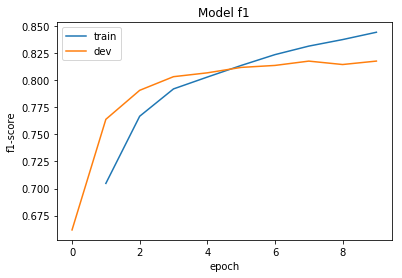

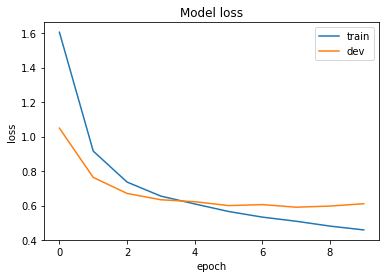

In [9]:

%matplotlib inline
import matplotlib.pyplot as plt


# summarize history for f1
plt.plot(history2.history['f1'])
plt.plot(history2.history['val_f1'])
plt.title('Model f1')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

In [10]:
from sklearn import metrics

y_prob = model2.predict(test_data, batch_size=32, verbose=0)
print(metrics.classification_report(y_test, (y_prob > 0.5).astype('int32')))

              precision    recall  f1-score   support

           0       0.89      0.59      0.71       586
           1       0.97      0.82      0.89       578
           2       0.98      0.97      0.97       625
           3       0.86      0.75      0.80       594
           4       0.82      0.85      0.84       634
           5       0.75      0.54      0.63       619
           6       0.87      0.73      0.79       628
           7       0.85      0.88      0.87       575
           8       0.81      0.65      0.72       601
           9       0.74      0.61      0.67       627
          10       0.77      0.61      0.68       584
          11       0.91      0.82      0.86       627
          12       0.89      0.77      0.83       627
          13       0.91      0.85      0.88       620
          14       0.94      0.74      0.83       561
          15       0.85      0.59      0.70       609
          16       0.91      0.85      0.88       600
          17       0.94    

In [8]:
#MULTI STACK

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.callbacks import ModelCheckpoint
from keras.layers.embeddings import Embedding
from keras_tqdm import TQDMNotebookCallback
from keras.models import Model
from keras.layers import Dense, Dropout, Bidirectional, Input
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras import backend as K

LSTM_SIZE = 100
DENSE = 200
N_CLASSES = 20

inputs = Input((MAX_SEQUENCE_LENGTH,))
embeddings = Embedding(MAX_WORDS+2,EMBEDDING_DIM, weights=[embedding_matrix], 
                    input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False)(inputs)
drop_emb = Dropout(0.2)(embeddings)
bilstm = Bidirectional(LSTM(units=LSTM_SIZE, return_sequences=True,recurrent_dropout = 0.2))(drop_emb)
unilstm =LSTM(units=LSTM_SIZE, return_sequences=True,recurrent_dropout = 0.2)(bilstm)
x, attn = DeepAttention(return_attention=True)(unilstm)
out = Dense(units=DENSE, activation="tanh")(x)
out = Dense(units=N_CLASSES, activation="softmax")(out)
model2 = Model(inputs, out)

print(model2.summary())
model2.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=[precision, recall, f1, accuracy])

checkpoint = ModelCheckpoint('keras_BiLSTM+attn_model', monitor='val_f1', verbose=1, save_best_only=True, mode='max')

history2 = model2.fit(train_data, y_train,
              batch_size=32,
              epochs=10,
              verbose = 0,
              callbacks=[checkpoint,TQDMNotebookCallback()],
              validation_data=(dev_data, y_train_dev),
              shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 600, 300)          6000600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 600, 300)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 600, 200)          320800    
_________________________________________________________________
lstm_4 (LSTM)                (None, 600, 100)          120400    
_________________________________________________________________
deep_attention_2 (DeepAttent [(None, 100), (None, 600) 10201     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               20200     
__________


Epoch 00001: val_f1 improved from -inf to 0.64225, saving model to keras_BiLSTM+attn_model



Epoch 00002: val_f1 improved from 0.64225 to 0.72985, saving model to keras_BiLSTM+attn_model



Epoch 00003: val_f1 improved from 0.72985 to 0.76119, saving model to keras_BiLSTM+attn_model



Epoch 00004: val_f1 improved from 0.76119 to 0.79089, saving model to keras_BiLSTM+attn_model



Epoch 00005: val_f1 improved from 0.79089 to 0.79172, saving model to keras_BiLSTM+attn_model



Epoch 00006: val_f1 improved from 0.79172 to 0.79769, saving model to keras_BiLSTM+attn_model



Epoch 00007: val_f1 improved from 0.79769 to 0.80772, saving model to keras_BiLSTM+attn_model



Epoch 00008: val_f1 did not improve from 0.80772



Epoch 00009: val_f1 improved from 0.80772 to 0.80932, saving model to keras_BiLSTM+attn_model



Epoch 00010: val_f1 improved from 0.80932 to 0.81880, saving model to keras_BiLSTM+attn_model


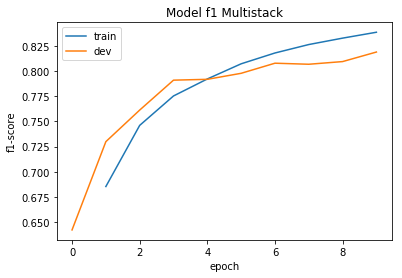

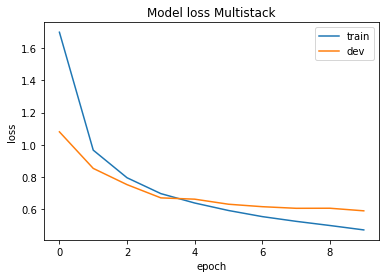

In [9]:

%matplotlib inline
import matplotlib.pyplot as plt


# summarize history for f1
plt.plot(history2.history['f1'])
plt.plot(history2.history['val_f1'])
plt.title('Model f1 Multistack')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss Multistack')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

In [10]:
from sklearn import metrics

y_prob = model2.predict(test_data, batch_size=32, verbose=0)
print(metrics.classification_report(y_test, (y_prob > 0.5).astype('int32')))

              precision    recall  f1-score   support

           0       0.85      0.62      0.71       586
           1       0.95      0.84      0.89       578
           2       0.98      0.95      0.97       625
           3       0.87      0.73      0.79       594
           4       0.88      0.82      0.85       634
           5       0.70      0.61      0.65       619
           6       0.89      0.73      0.80       628
           7       0.85      0.88      0.86       575
           8       0.82      0.69      0.75       601
           9       0.72      0.60      0.66       627
          10       0.85      0.52      0.65       584
          11       0.92      0.81      0.86       627
          12       0.88      0.78      0.83       627
          13       0.86      0.87      0.87       620
          14       0.91      0.77      0.83       561
          15       0.84      0.59      0.70       609
          16       0.91      0.84      0.87       600
          17       0.93    